#### Authorship

Created by Shawn Tan (banchan@gmail.com) for DJ BambahMukku Lab

#### Changelog

2/24/25 - Added imports and loading of face_rhythm data, as well as raw displacement over time.

#### Description
- Processes bonsai output for stimuli alignment.
- Analyzes face_rhythm data

#### Instructions
- Install face_rhythm (this script calls on some functions from there)
- Install seaborn (plotting library)
- `conda activate face_rhythm`
- `jupyter notebook`

#### Project organization
- face_rhythm folder (clone modified repository https://github.com/banchan86/face-rhythm-DJ)
- airpuff data folder
  - experimental day folder
    - subject ID folder
      - bonsai output
      - facerhythm output

# Imports

In [120]:
import seaborn as sns
import face_rhythm as fr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Individual Session Analysis

# Load session data

In [121]:
# Define constants for folder location
data_folder = "Airpuff_Data"
experiment_day = "03182025_Cage_PN37"
subjectID = "LLM"

In [122]:
session_folder = Path("../../").resolve() / data_folder / experiment_day / subjectID


# Align bonsai data

In [123]:
# Import timestamp csv as a pandas dataframe
video_timestamp_csv = next(file for file in session_folder.glob("*.csv") if "video" in file.name)
video_timestamp_df = pd.read_csv(video_timestamp_csv, parse_dates = [1])
video_timestamp_df.head()

,Frame,Timestamp
0,0,2025-03-18 15:31:31.253670400-07:00
1,1,2025-03-18 15:31:31.263104-07:00
2,2,2025-03-18 15:31:31.273113600-07:00
3,3,2025-03-18 15:31:31.283033600-07:00
4,4,2025-03-18 15:31:31.293030400-07:00


In [124]:
# Import TTL readout csv as a pandas dataframe
TTL_readout_csv = next(file for file in session_folder.glob("*.csv") if "TTL_received" in file.name)
TTL_readout_df = pd.read_csv(TTL_readout_csv, header = None, names = ["TTL", "Timestamp"], parse_dates = [1])
TTL_readout_df = TTL_readout_df.drop(index=0)
TTL_readout_df = TTL_readout_df.reset_index(drop=True)
TTL_readout_df.head()

,TTL,Timestamp
0,True,2025-03-18 15:32:05.892812800-07:00
1,False,2025-03-18 15:32:05.941747200-07:00
2,True,2025-03-18 15:32:34.906611200-07:00
3,False,2025-03-18 15:32:34.955904-07:00
4,True,2025-03-18 15:33:00.918118400-07:00


In [125]:
# Zero Timestamps to experiment start time
experiment_start = video_timestamp_df.iloc[0, 1]

video_timestamp_df["Time_since_start"] = video_timestamp_df.iloc[:, 1] - experiment_start
video_timestamp_df["Experiment_time_seconds"] = video_timestamp_df["Time_since_start"].dt.total_seconds()
video_timestamp_df = video_timestamp_df.drop(columns=["Time_since_start"])

TTL_readout_df["Time_since_start"] = TTL_readout_df.iloc[:, 1] - experiment_start
TTL_readout_df["Experiment_time_seconds"] = TTL_readout_df["Time_since_start"].dt.total_seconds()
TTL_readout_df = TTL_readout_df.drop(columns=["Time_since_start"])

In [126]:
# Verify dataframe
video_timestamp_df.head()

,Frame,Timestamp,Experiment_time_seconds
0,0,2025-03-18 15:31:31.253670400-07:00,0.000000
1,1,2025-03-18 15:31:31.263104-07:00,0.009434
2,2,2025-03-18 15:31:31.273113600-07:00,0.019443
3,3,2025-03-18 15:31:31.283033600-07:00,0.029363
4,4,2025-03-18 15:31:31.293030400-07:00,0.039360


In [127]:
# Verify dataframe
TTL_readout_df.head()

,TTL,Timestamp,Experiment_time_seconds
0,True,2025-03-18 15:32:05.892812800-07:00,34.639142
1,False,2025-03-18 15:32:05.941747200-07:00,34.688077
2,True,2025-03-18 15:32:34.906611200-07:00,63.652941
3,False,2025-03-18 15:32:34.955904-07:00,63.702234
4,True,2025-03-18 15:33:00.918118400-07:00,89.664448


In [128]:
# Find video frame frame that comes after TTL is received

# Extract TTL on times
TTL_on_times = TTL_readout_df[TTL_readout_df["TTL"] == True]["Experiment_time_seconds"].reset_index(drop=True)

# Extract video timestamps and frame numbers
frame_times = video_timestamp_df.iloc[:, 2]
frame_numbers = video_timestamp_df.iloc[:, 0]

# Use searchsorted to find matching frame indices
indices = frame_times.searchsorted(TTL_on_times)

# Get corresponding frame numbers
matched_frames = frame_numbers.iloc[indices].reset_index(drop=True)
matched_frame_times = frame_times.iloc[indices].reset_index(drop=True)

# Create a result DataFrame
airpuff_df = pd.DataFrame({
    "Matched_frame": matched_frames,
    "TTL_on_time": TTL_on_times,
    "Frame_time": matched_frame_times
})

In [129]:
# Define airpuff levels
# Note - do not do any filtering here, there will be automatic and manual filtering later
# Should match total number of trials

airpuff_df["PSI"] = (
    [0.1] * 3 +
    [0.25] * 3 +
    [0.5] * 3 +
    [0.75] * 3 +
    [1.0] * 6
)

In [130]:
airpuff_df.head()

,Matched_frame,TTL_on_time,Frame_time,PSI
0,3463,34.639142,34.643699,0.10
1,6363,63.652941,63.655565,0.10
2,8963,89.664448,89.666394,0.10
3,11564,115.680346,115.687270,0.25
4,13564,135.694554,135.695245,0.25


In [106]:
# Define the output folder path
output_folder = session_folder / "bonsai_aligned"

# Create the folder if it doesn't exist
output_folder.mkdir(exist_ok=True)

# Save dataframes
video_timestamp_df.to_csv(output_folder / "video_aligned.csv", index = False)
TTL_readout_df.to_csv(output_folder / "TTL_aligned.csv", index = False)
airpuff_df.to_csv(output_folder / "all_airpuff_aligned.csv", index = False)

# Load bonsai aligned data

In [81]:
#TODO

# Load face_rhythm data

In [131]:
raw_data = fr.h5_handling.simple_load(session_folder / "analysis_files" / "PointTracker.h5")

# Calculate frame-wise displacement

In [132]:
# Compute displacement: difference between consecutive frames
delta = np.diff(raw_data["points_tracked"]["0"], axis = 0) # Shape: (33484, 185, 2)

# Compute Euclidean distance for each point
displacement = np.linalg.norm(delta, axis=2)  # Shape: (33484, 185)

# Compute mean displacement across all points
mean_displacement = np.mean(displacement, axis=1)  # Shape: (33484,)

# Pad mean displacement with one frame at start as it will be n-1
mean_displacement = np.insert(mean_displacement, 0, 0)

# Plot frame-wise displacement over time with airpuffs overlaid

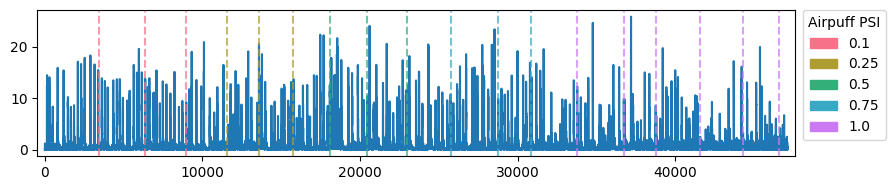

In [147]:
# Set up base figure
plt.figure(figsize=(10, 2))
sns.lineplot(x=range(len(mean_displacement)), y=mean_displacement)

# Pick a color palette based on unique PSI levels
unique_psi = sorted(airpuff_df["PSI"].unique())
palette = sns.color_palette("husl", len(unique_psi))

# Map each PSI value to a color
psi_to_color = {psi: palette[i] for i, psi in enumerate(unique_psi)}

# Step 3: Overlay vertical lines for airpuffs, colored by PSI
for _, row in airpuff_df.iterrows():
    psi = row["PSI"]
    color = psi_to_color[psi]
    plt.axvline(x=row["Matched_frame"], color=color, linestyle="--", alpha=0.7)

# Create legend handles manually
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor=color, label=f"{psi}") for psi, color in psi_to_color.items()]
plt.legend(handles=legend_elements, title="Airpuff PSI", bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0)

plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.margins(x=0.01)

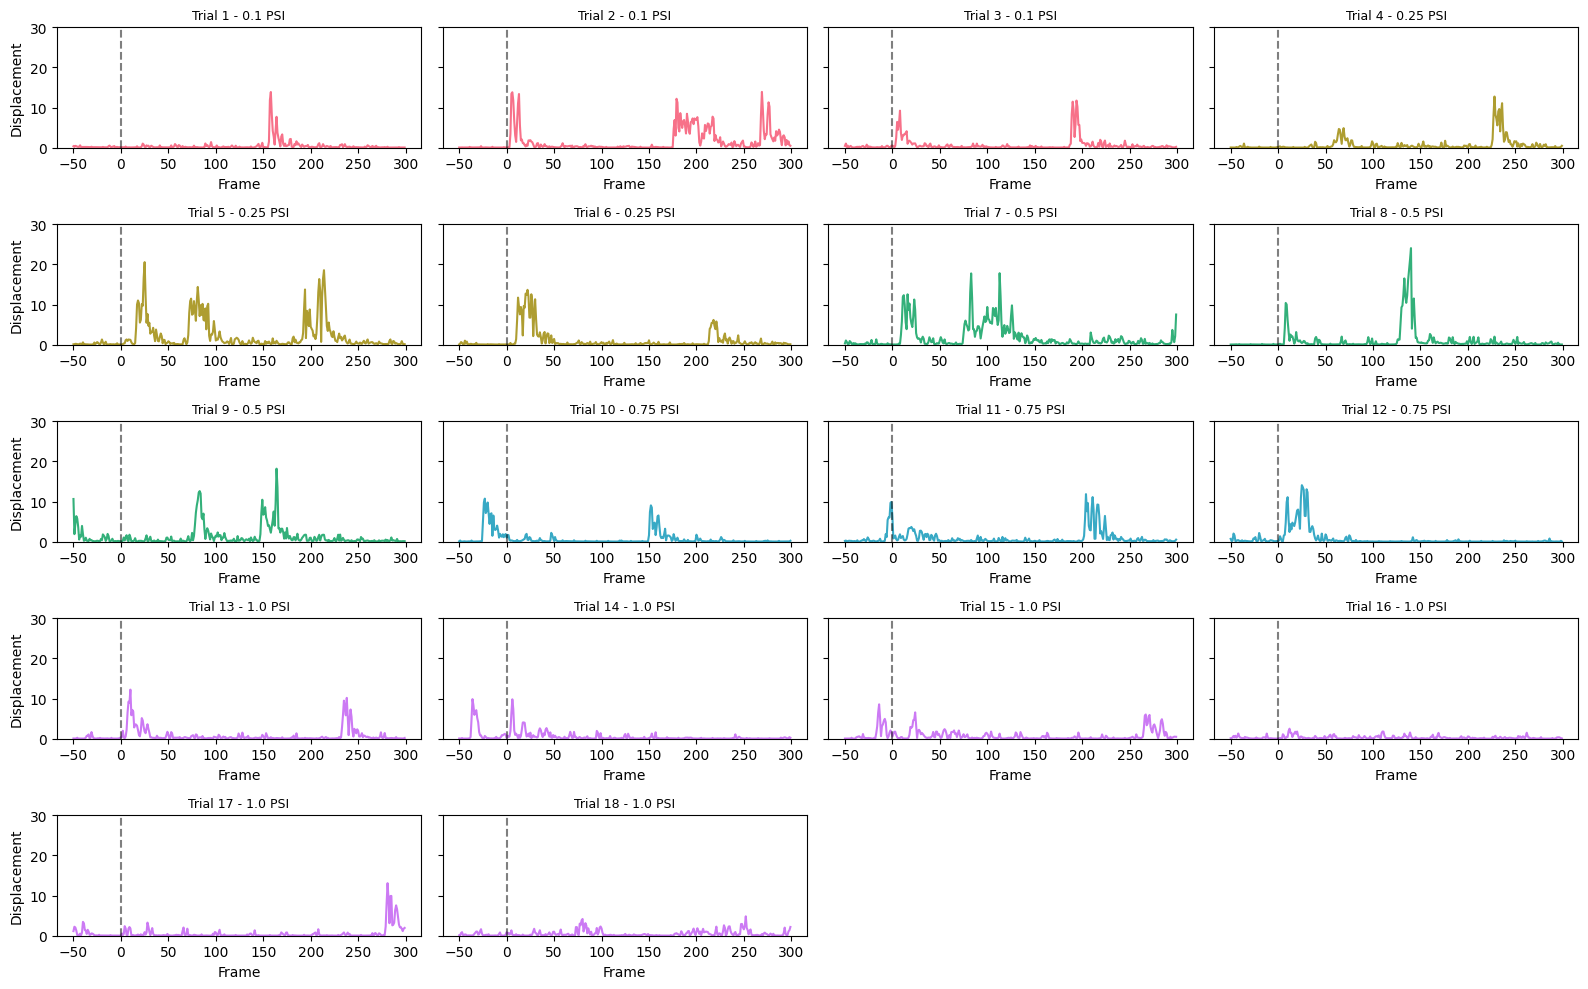

In [154]:
# Generates graphs for each simulus

# Timeframe
pre_frames = 50
post_frames = 300


import math

# Layout settings
n_trials = len(airpuff_df)
n_cols = 4  # number of plots per row
n_rows = math.ceil(n_trials / n_cols)

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2), sharey=True)
axes = axes.flatten()  # make it easy to index

for i, row in airpuff_df.iterrows():
    ax = axes[i]
    center = int(row["Matched_frame"])
    psi = row["PSI"]

    start = max(center - pre_frames, 0)
    end = min(center + post_frames, len(mean_displacement))

    segment = mean_displacement[start:end]
    x = np.arange(-pre_frames, len(segment) - pre_frames)

    sns.lineplot(x=x, y=segment, ax=ax, color=psi_to_color[psi])
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f"Trial {i+1} - {psi} PSI", fontsize=9)
    ax.set_ylim(0, 30)
    ax.set_xlabel("Frame")
    ax.set_ylabel("Displacement")

# Remove unused axes if n_trials doesn't fill the grid
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Supplementary:TTL characterisation

In [23]:
# Shawn's notes 3/26/25
# I wrote this section to characterize both the duration and latency for the TTL.
# Dont need to run this section again unless you suspect something is obviously wrong
TTL_sent_csv = next(file for file in Path(session_folder).glob("*.csv") if "TTL_sent" in file.name)
TTL_sent_df = pd.read_csv(TTL_sent_csv, header = None, names = ["TTL", "Timestamp"], parse_dates = [1])
TTL_sent_df.head()


,TTL,Timestamp
0,True,2025-03-18 15:32:05.887667200-07:00
1,False,2025-03-18 15:32:05.950924800-07:00
2,True,2025-03-18 15:32:34.904243200-07:00
3,False,2025-03-18 15:32:34.966822400-07:00
4,True,2025-03-18 15:33:00.914316800-07:00


In [24]:
print(TTL_readout_df.dtypes)
print(TTL_sent_df.dtypes)

TTL                               bool
Timestamp    datetime64[ns, UTC-07:00]
dtype: object
TTL                               bool
Timestamp    datetime64[ns, UTC-07:00]
dtype: object


In [32]:
# Calculate TTL duration and check for any outlier values
TTL_on_times = TTL_readout_df[TTL_readout_df["TTL"] == True]["Timestamp"].reset_index(drop=True)
TTL_off_times = TTL_readout_df[TTL_readout_df["TTL"] == False]["Timestamp"].reset_index(drop=True)
durations = TTL_off_times - TTL_on_times
durations_in_milliseconds = durations.dt.total_seconds()*1000

print(durations_in_milliseconds)

0     48.9344
1     49.2928
2     49.2288
3     49.0496
4     53.2352
5     48.9984
6     48.9600
7     49.0880
8     49.0240
9     53.1328
10    53.2352
11    49.1776
12    53.0816
13    49.2032
14    49.1904
15    49.1648
16    53.3376
17    49.3056
Name: Timestamp, dtype: float64


In [34]:
# Calculate TTL latency
TTL_sent_times = TTL_sent_df[TTL_sent_df["TTL"] == True]["Timestamp"].reset_index(drop=True)
TTL_read_times = TTL_readout_df[TTL_readout_df["TTL"] == True]["Timestamp"].reset_index(drop=True)
latencies = TTL_read_times - TTL_sent_times
latencies_in_milliseconds = latencies.dt.total_seconds()*1000

print(latencies_in_milliseconds)


0     5.1456
1     2.3680
2     3.8016
3     2.5472
4     1.3824
5     4.2240
6     2.6752
7     4.6720
8     3.2640
9     1.7024
10    1.3696
11    2.8160
12    1.7792
13    4.0064
14    4.3008
15    4.6336
16    1.4720
17    2.7136
Name: Timestamp, dtype: float64


# Supplementary: face_rhythm data inspection 

In [ ]:
# Shawn's notes 2/24/25
# I wrote this section to inspect the point tracking data produced by face-rhythm and write some notes.
# Doesnt need to be run (unless you run into some errors at some point and need to figure out what is wrong)
# key 1 - mask is a numpy.ndarray with a boolean value for every pixel in the (vertical video) x (horizontal video) frame. ROI
# key 2 - mesh_d0 is a numpy.ndarray that is the (number of points) x (x and y coords). unclear what it is
# key 3 - neighbors is a numpy.ndarray that is the (number of points) x (list of 40 neighbours), probably the index of the closest neighbours
# key 4 - point_positions is the (number of points) x (x and y coords). seem to be the initial mesh point position
# key 5 - points tracked is the motherload. its a (frame)x(number of points)x (x and y coords). 

In [ ]:
raw_data = fr.h5_handling.simple_load("analysis_files\\PointTracker.h5")

In [18]:
for key in raw_data.keys():
    print(key, type(raw_data[key]))

mask <class 'numpy.ndarray'>
mesh_d0 <class 'numpy.ndarray'>
neighbors <class 'numpy.ndarray'>
point_positions <class 'numpy.ndarray'>
points_tracked <class 'dict'>
violations <class 'dict'>


(750, 1440)


<Axes: >

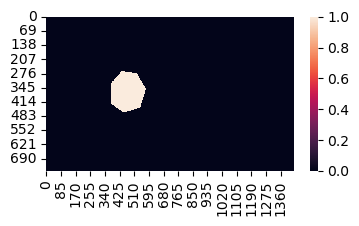

In [33]:
# mask visualization section
print(raw_data["mask"].shape)
plt.figure(figsize=(4, 2))
sns.heatmap(raw_data["mask"])

(185, 2)


<Axes: >

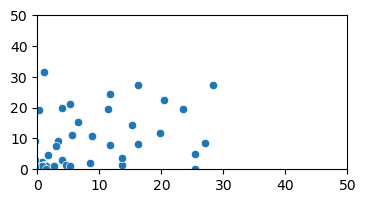

In [47]:
# mesh_d0 visualization section
print(raw_data["mesh_d0"].shape)
plt.figure(figsize=(4, 2))
plt.xlim(0, 50)
plt.ylim(0, 50)
sns.scatterplot(x = raw_data["mesh_d0"][:,0], y = raw_data["mesh_d0"][:,1], )

In [50]:
# neighbours visualization section
print(raw_data["neighbors"].shape)
print(raw_data["neighbors"])

(185, 40)
[[  0   1   9 ...  58  24  57]
 [  1   0   2 ...  49  60  61]
 [  2   1   3 ...  61  29  37]
 ...
 [182 173 181 ... 146 139 133]
 [183 174 182 ... 140 178 155]
 [184 180 181 ... 144 152 156]]


(185, 2)


<Axes: >

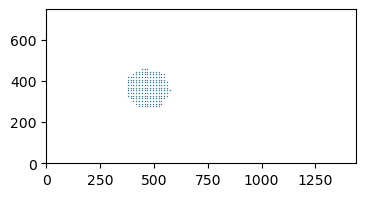

In [62]:
# point_positions visualization section
print(raw_data["point_positions"].shape)
plt.figure(figsize=(4, 2))
plt.xlim(0, 1440)
plt.ylim(0, 750)
sns.scatterplot(x = raw_data["point_positions"][:,0], y = raw_data["point_positions"][:,1], s =1)

In [82]:
# points_tracked visualization section
print(raw_data["points_tracked"]["0"].shape)

(33485, 185, 2)


In [89]:
# violations section
print(raw_data["violations"]["0"])

{'col': array([ 16,  25,  26, ..., 151, 152, 153]), 'data': array([ True,  True,  True, ...,  True,  True,  True]), 'row': array([21548, 21548, 21548, ..., 31760, 31760, 31760]), 'shape': array([33485,   185])}
